### 바벨스피치 - 텐서플로우 음성인식 예제

[light_weight_cnn](https://www.kaggle.com/alphasis/light-weight-cnn-lb-0-74)

### 머리말
- 이 노트북은 light-weight CNN을 만드는 것을 목표로합니다.
- 그것은 리샘플링 된 wav 파일 (속도 8000)의 specgram을 입력으로 사용합니다.
- LB 0.74를 얻으려면 epoch를 5로 설정하고 chop_audio (num = 1000)을 설정하고 모든 Conv 레이어 매개 변수를 두 배로 설정해야합니다.
- 이 스크립트는 Alex Ozerin의 기준선에 약간의 영향을 미치지 만 원본 WAV 파일 (16000 샘플 속도)을 사용하면 더 높은 점수를 얻을 수 있다고 생각합니다.


### File Structure
- This script assumes data are stored in following strcuture:

speech

├── test

│ └── audio #test wavfiles

├── train

│ ├── audio #train wavfiles

└── model #store models

│

└── out #store sub.csv

### 이 스크립트 개선
- 이것은 light-weight CNN이기 때문에 성능이 제한적입니다. 실력을 향상시키는 몇 가지 방법이 있습니다.
- 샘플링 된 원본 wav 파일을 대신 사용하십시오.
- chop_audio를 사용하여 더 많은 '무음' wav 파일을 만듭니다.
- 더 깊은 CNN을 구축하거나 RNN을 사용하십시오.
    - Train for longer epochs
    - After Words
    - It's still a long way to reach LB 0.88.
- 사실, 나는 CNN이 그 높은 곳에 도달 할 수 있을지 의심 스럽다.
- CNN을 사용하여 wav 파일에 라벨을 붙이는 것에 대한 의견 섹션에서 아이디어를 공유하십시오. 

In [2]:
import os
import numpy as np
from scipy.fftpack import fft
from scipy.io import wavfile
from scipy import signal
from glob import glob
import re
import pandas as pd
import gc
from scipy.io import wavfile

from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
import keras

Using TensorFlow backend.


- The original sample rate is 16000, and we will resample it to 8000 to reduce data size.

In [4]:
L = 16000
legal_labels = 'yes no up down left right on off stop go silence unknown'.split()

#src folders
root_path = r'.'
out_path = r'.'
model_path = r'.'
train_data_path = os.path.join(root_path, 'input', 'train', 'audio')
test_data_path = os.path.join(root_path, 'input', 'test', 'audio')

In [5]:
test_data_path

'./input/test/audio'

In [6]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    vals = 2.0/N * np.abs(yf[0:N//2])
    return xf, vals

def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [7]:
def list_wavs_fname(dirpath, ext='wav'):
    print(dirpath)
    fpaths = glob(os.path.join(dirpath, r'*/*' + ext))
    pat = r'.+/(\w+)/\w+\.' + ext + '$'
    labels = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            labels.append(r.group(1))
    pat = r'.+/(\w+\.' + ext + ')$'
    fnames = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            fnames.append(r.group(1))
    return labels, fnames

- pad_audio는 모두 16000(1 초) 미만의 오디오를 0으로 채워서 모두 길이가 동일하게 만듭니다.

- chop_audio는 16000보다 큰 오디오 (예 : 배경 노이즈 폴더의 wav 파일)를 16000 길이로 잘라냅니다. 또한 매개 변수 'num'이 주어지면 하나의 큰 wav 파일에서 여러 개의 청크가 만들어집니다.

- label_transform 라벨을 dummies 값으로 변환합니다. softmax와 함께 사용되어 라벨을 예측합니다.

In [8]:
def pad_audio(samples):
    if len(samples) >= L: return samples
    else: return np.pad(samples, pad_width=(L - len(samples), 0), mode='constant', constant_values=(0, 0))

def chop_audio(samples, L=16000, num=20):
    for i in range(num):
        beg = np.random.randint(0, len(samples) - L)
        yield samples[beg: beg + L]

def label_transform(labels):
    nlabels = []
    for label in labels:
        if label == '_background_noise_':
            nlabels.append('silence')
        elif label not in legal_labels:
            nlabels.append('unknown')
        else:
            nlabels.append(label)
    return pd.get_dummies(pd.Series(nlabels))

- 다음으로 위에서 선언 한 함수를 사용하여 x_train과 y_train을 생성합니다.
- label_index는 더미 값을 만들기 위해 팬더가 사용하는 인덱스입니다. 나중에 사용할 수 있도록 저장해야 합니다.

In [182]:
labels, fnames = list_wavs_fname(train_data_path)

new_sample_rate = 8000
y_train = []
x_train = []

./input/train/audio


In [10]:
len(labels)

64727

In [11]:
len(fnames)

64727

In [183]:
for label, fname in zip(labels, fnames):
    sample_rate, samples = wavfile.read(os.path.join(train_data_path, label, fname))
    samples = pad_audio(samples)
    if len(samples) > 16000:
        n_samples = chop_audio(samples)
    else: n_samples = [samples]
    for samples in n_samples:
        resampled = signal.resample(samples, int(new_sample_rate / sample_rate * samples.shape[0]))
        _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
        y_train.append(label)
        x_train.append(specgram)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [142]:
set(y_train)

{'_background_noise_',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'four',
 'go',
 'happy',
 'house',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'wow',
 'yes',
 'zero'}

In [168]:
len(x_train)

64841

In [15]:
x_train = np.array(x_train)
x_train = x_train.reshape(tuple(list(x_train.shape) + [1]))

In [35]:
x_train.shape

(64841, 99, 81, 1)

In [17]:
x_train.ndim

4

In [18]:
print(x_train, 1)

[[[[ -0.41745198]
   [ -0.24458005]
   [  2.79768968]
   ..., 
   [  2.6785953 ]
   [  2.09972167]
   [  0.05649049]]

  [[ -3.92316294]
   [  1.97709239]
   [  3.57352591]
   ..., 
   [  2.71785641]
   [  2.32498026]
   [  2.21249366]]

  [[  0.64336437]
   [  1.64219999]
   [  4.12746096]
   ..., 
   [  4.10343456]
   [  4.35154915]
   [  3.843153  ]]

  ..., 
  [[  1.0800848 ]
   [  4.27971888]
   [  4.92285776]
   ..., 
   [  3.15136075]
   [  2.60167027]
   [  3.49682283]]

  [[  1.16532815]
   [  4.09331656]
   [  5.81963539]
   ..., 
   [  0.47378564]
   [  2.68074727]
   [  3.37772918]]

  [[  1.88737643]
   [  4.56877661]
   [  4.93868923]
   ..., 
   [  3.16269755]
   [  0.12078514]
   [  1.35775983]]]


 [[[  0.22588514]
   [  6.04990959]
   [  5.96136904]
   ..., 
   [ -0.03131152]
   [ -0.72028702]
   [ -5.2983737 ]]

  [[  0.55752128]
   [  5.2904315 ]
   [  5.54295397]
   ..., 
   [ -2.71505809]
   [ -4.5200448 ]
   [ -2.51112723]]

  [[  2.77723932]
   [  5.58479166]
  

In [172]:
y_train = label_transform(y_train)
label_index = y_train.columns.values

In [173]:
label_index

array(['down', 'go', 'left', 'no', 'off', 'on', 'right', 'silence', 'stop',
       'unknown', 'up', 'yes'], dtype=object)

In [160]:
y_train = y_train.values
y_train = np.array(y_train)
#del labels, fnames
#gc.collect()

In [174]:
y_train

,down,go,left,no,off,on,right,silence,stop,unknown,up,yes
0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,0,1,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,0,0
8,0,0,0,0,0,0,0,1,0,0,0,0
9,0,0,0,0,0,0,0,1,0,0,0,0


In [149]:
y_train.shape

(64841, 12)

In [23]:
input_shape = (99, 81, 1)
nclass = 12

In [24]:
inp = Input(shape=input_shape)
norm_inp = BatchNormalization()(inp)

In [49]:
inp

<tf.Tensor 'input_1:0' shape=(?, 99, 81, 1) dtype=float32>

In [50]:
norm_inp

<tf.Tensor 'batch_normalization_1/cond/Merge:0' shape=(?, 99, 81, 1) dtype=float32>

In [25]:
img_1 = Convolution2D(8, kernel_size=2, activation=activations.relu)(norm_inp)
img_1 = Convolution2D(8, kernel_size=2, activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Convolution2D(16, kernel_size=3, activation=activations.relu)(img_1)
img_1 = Convolution2D(16, kernel_size=3, activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Flatten()(img_1)

In [26]:
img_1

<tf.Tensor 'flatten_1/Reshape:0' shape=(?, ?) dtype=float32>

In [27]:
dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(img_1))
dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(dense_1))
dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

In [28]:
dense_1

<tf.Tensor 'dense_3/Softmax:0' shape=(?, 12) dtype=float32>

In [29]:
model = models.Model(inputs=inp, outputs=dense_1)
opt = optimizers.Adam()

In [78]:
model

In [79]:
opt

In [30]:
model.compile(optimizer=opt, loss=losses.binary_crossentropy)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 99, 81, 1)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 99, 81, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 80, 8)         40        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 79, 8)         264       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 39, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 39, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 37, 16)        1168      
__________

In [14]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=2017)

In [36]:
x_train.shape

(64841, 99, 81, 1)

In [84]:
x_valid.shape

(6485, 99, 81, 1)

In [85]:
y_train.shape

(58356, 12)

In [86]:
y_valid.shape

(6485, 12)

In [62]:
model.fit(x_train, y_train, batch_size=16, validation_data=(x_valid, y_valid), epochs=50, shuffle=True, verbose=2)

Train on 58356 samples, validate on 6485 samples
Epoch 1/50
464s - loss: 0.0524 - val_loss: 0.0419
Epoch 2/50
502s - loss: 0.0474 - val_loss: 0.0396
Epoch 3/50
396s - loss: 0.0436 - val_loss: 0.0348
Epoch 4/50
397s - loss: 0.0410 - val_loss: 0.0337
Epoch 5/50
405s - loss: 0.0386 - val_loss: 0.0326
Epoch 6/50
393s - loss: 0.0371 - val_loss: 0.0301
Epoch 7/50
395s - loss: 0.0349 - val_loss: 0.0302
Epoch 8/50
395s - loss: 0.0337 - val_loss: 0.0271
Epoch 9/50
393s - loss: 0.0321 - val_loss: 0.0274
Epoch 10/50
391s - loss: 0.0305 - val_loss: 0.0260
Epoch 11/50
392s - loss: 0.0303 - val_loss: 0.0287
Epoch 12/50
392s - loss: 0.0291 - val_loss: 0.0265
Epoch 13/50
394s - loss: 0.0297 - val_loss: 0.0244
Epoch 14/50
391s - loss: 0.0269 - val_loss: 0.0237
Epoch 15/50
392s - loss: 0.0267 - val_loss: 0.0255
Epoch 16/50
393s - loss: 0.0261 - val_loss: 0.0238
Epoch 17/50
392s - loss: 0.0259 - val_loss: 0.0252
Epoch 18/50
392s - loss: 0.0255 - val_loss: 0.0226
Epoch 19/50
392s - loss: 0.0250 - val_loss

In [63]:
model.save(os.path.join(model_path, 'cnn_epochs500_20171211.model'))

In [67]:
def test_data_generator(batch=16):
    fpaths = glob(os.path.join(test_data_path, '*wav'))
    i = 0
    for path in fpaths:
        if i == 0:
            imgs = []
            fnames = []
        i += 1
        rate, samples = wavfile.read(path)
        samples = pad_audio(samples)
        resampled = signal.resample(samples, int(new_sample_rate / rate * samples.shape[0]))
        _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
        imgs.append(specgram)
        fnames.append(path.split('\\')[-1])
        if i == batch:
            i = 0
            imgs = np.array(imgs)
            imgs = imgs.reshape(tuple(list(imgs.shape) + [1]))
            yield fnames, imgs
    if i < batch:
        imgs = np.array(imgs)
        imgs = imgs.reshape(tuple(list(imgs.shape) + [1]))
        yield fnames, imgs
    raise StopIteration()

In [3]:
#exit() #delete this
#del x_train, y_train
#gc.collect()

In [31]:
from keras.models import load_model
#model = load_model('cnn_epochs3_20171211.model')
model = load_model('cnn_epochs500_20171211.model')

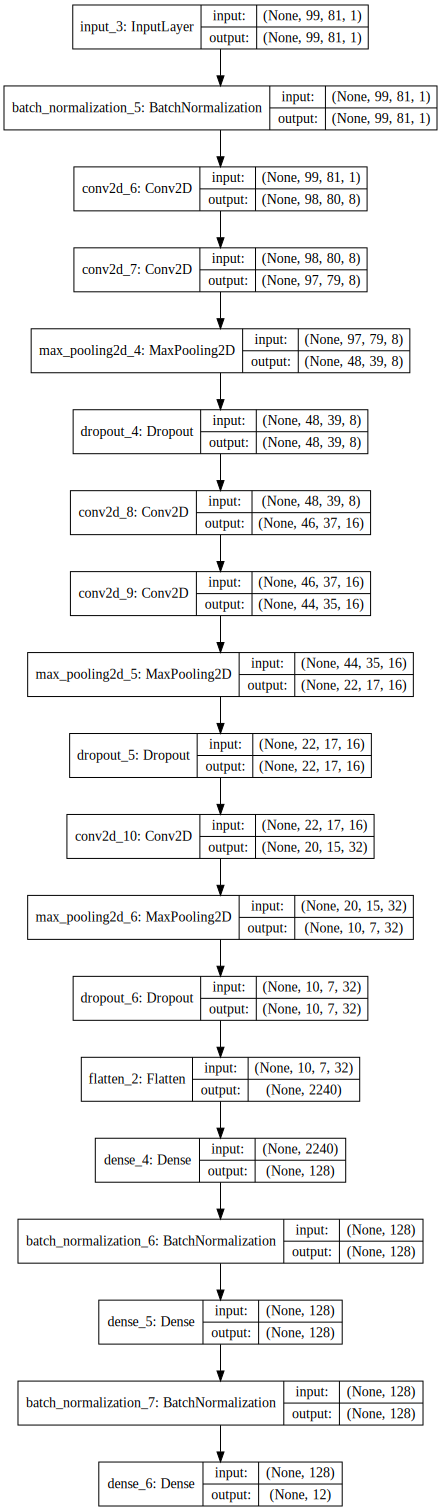

In [33]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [32]:
from keras.models import Model

In [34]:
intermediate_layer_model_flatten = Model(input=model.input,output=model.layers[13].output)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("fl..., inputs=Tensor("in...)`
  if __name__ == '__main__':


In [47]:
flatten_value = intermediate_layer_model_flatten.predict(x_train)

In [48]:
type(flatten_value)

numpy.ndarray

In [50]:
flatten_value.shape

(64841, 2240)

In [57]:
np.average(flatten_value, axis=1)

array([ 2.50764418,  1.67390943,  1.85464823, ...,  5.86894512,
        5.76655436,  6.44726419], dtype=float32)

In [95]:
test_data_path = os.path.join(root_path, 'input', 'test', 'audio')

In [96]:
results = []
#results = np.array([], dtype=np.float64)
for fnames, imgs in test_data_generator(batch=32):
    predicts = intermediate_layer_model_flatten.predict(imgs)
    #predicts = model.predict(imgs)
    #predicts = np.argmax(predicts, axis=1)
    #predicts = [label_index[p] for p in predicts]
    results.extend(predicts)
    #results = np.append(results, predicts)

In [97]:
results2 = np.array(results)

In [98]:
results2.shape

(158538, 2240)

In [99]:
type(results2)

numpy.ndarray

In [100]:
print(results2, 1)

[[   0.            0.            0.         ...,    0.            0.            0.        ]
 [   0.            0.            0.         ...,    0.           40.53181458
    11.68374443]
 [   0.            4.41220617    0.         ...,    0.           23.75778961
    15.42424965]
 ..., 
 [   0.            0.            0.         ...,    0.           17.37981033
     0.        ]
 [   0.            0.            0.         ...,    0.            0.            0.        ]
 [   0.          106.24515533    0.         ...,    0.            0.            0.        ]] 1


In [101]:
#https://flonelin.wordpress.com/2016/07/26/tuning-xgboostextream-gradient-boosting/
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=100):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.03
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = 12
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['seed'] = 2310 # 초기값 설정 랜덤 안되게
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y) # D매트릭스로 바꿔줘야 한다.
    feature_names = xgtrain.feature_names

    # test의 타겟값을 넣은 xgb model
    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    # test의 타겟값을 넣지 않은 xgb model
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model, feature_names

In [102]:
import xgboost as xgb
import random
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.preprocessing import Imputer

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [119]:
#y_train = label_transform(y_train)
#label_index = y_train.columns.values

In [188]:
y_train

['_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_background_noise_',
 '_backgrou

In [189]:
y_train = label_transform(y_train)
label_index = y_train.columns.values

In [190]:
y_train.shape

(64841, 12)

In [193]:
type(y_train)

pandas.core.frame.DataFrame

In [195]:
y_train2 = y_train.apply(lambda x: x.argmax(), axis=1)

In [196]:
y_train2.shape

(64841,)

In [197]:
target_num_map = {'down':0, 'go':1, 'left':2, 'no':3, 'off':4, 'on':5, 'right':6, 'silence':7, 'stop':8, 'unknown':9, 'up':10, 'yes':11}
train_y3 = np.array(y_train2.apply(lambda x: target_num_map[x]))
train_y3

array([7, 7, 7, ..., 9, 9, 9])

In [127]:
flatten_value.shape

(64841, 2240)

In [198]:
train_y3.shape

(64841,)

In [199]:
cv_scores = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(flatten_value.shape[0])):
        dev_X, val_X = flatten_value[dev_index,:], flatten_value[val_index,:]
        dev_y, val_y = train_y3[dev_index], train_y3[val_index]
        preds, model, feature_names = runXGB(dev_X, dev_y, val_X, val_y)
        cv_scores.append(log_loss(val_y, preds))
        print(cv_scores)
        break

[0]	train-mlogloss:2.38426	test-mlogloss:2.38767
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:2.2944	test-mlogloss:2.30098
[2]	train-mlogloss:2.21275	test-mlogloss:2.22268
[3]	train-mlogloss:2.13933	test-mlogloss:2.15251
[4]	train-mlogloss:2.07213	test-mlogloss:2.08839
[5]	train-mlogloss:2.00982	test-mlogloss:2.02871
[6]	train-mlogloss:1.95233	test-mlogloss:1.97369
[7]	train-mlogloss:1.89835	test-mlogloss:1.92237
[8]	train-mlogloss:1.84808	test-mlogloss:1.87459
[9]	train-mlogloss:1.80042	test-mlogloss:1.82915
[10]	train-mlogloss:1.75519	test-mlogloss:1.78589
[11]	train-mlogloss:1.71235	test-mlogloss:1.74498
[12]	train-mlogloss:1.67208	test-mlogloss:1.70618
[13]	train-mlogloss:1.63392	test-mlogloss:1.6699
[14]	train-mlogloss:1.59742	test-mlogloss:1.63544
[15]	train-mlogloss:1.56215	test-mlogloss:1.60195
[16]	train-mlogloss:1.52827	test-mlogloss:1.56992
[17]	train-

In [200]:
preds, model, feature_names = runXGB(flatten_value, train_y3, results2, num_rounds=100)
out_df = pd.DataFrame(preds)

In [201]:
out_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.015153,0.026533,0.017885,0.612472,0.013766,0.016551,0.015472,0.010845,0.016850,0.217938,0.013874,0.022661
1,0.022346,0.019199,0.022652,0.017680,0.023697,0.019577,0.022004,0.015480,0.029170,0.748798,0.034375,0.025025
2,0.064725,0.066459,0.031108,0.033568,0.034871,0.048163,0.038818,0.022710,0.039976,0.546682,0.043413,0.029506
3,0.025638,0.031667,0.029949,0.027699,0.026587,0.025199,0.029051,0.020113,0.103115,0.565162,0.080615,0.035205
4,0.009387,0.012168,0.009700,0.009681,0.009416,0.009226,0.011277,0.007416,0.010037,0.891172,0.010335,0.010187


In [203]:
out_df_label = out_df.apply(np.argmax, axis=1)

In [205]:
out_df_label.head()

0    3
1    9
2    9
3    9
4    9
dtype: int64

In [207]:
out_df_label.shape

(158538,)

In [209]:
label_index

array(['down', 'go', 'left', 'no', 'off', 'on', 'right', 'silence', 'stop',
       'unknown', 'up', 'yes'], dtype=object)

In [210]:
out_df_label2 = [label_index[p] for p in out_df_label]

In [211]:
out_df_label2

['no',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'go',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'no',
 'stop',
 'unknown',
 'down',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'down',
 'unknown',
 'unknown',
 'unknown',
 'stop',
 'unknown',
 'unknown',
 'go',
 'unknown',
 'unknown',
 'unknown',
 'on',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'yes',
 'no',
 'no',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'stop',
 'unknown',
 'up',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'silence',
 'unknown',
 'no',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'down',
 'no',
 'unknown',
 'un

In [213]:
df = pd.read_csv('sub2.csv')
df

,fname,label
0,clip_000044442.wav,no
1,clip_0000adecb.wav,unknown
2,clip_0000d4322.wav,unknown
3,clip_0000fb6fe.wav,stop
4,clip_0001d1559.wav,unknown
5,clip_0002256ed.wav,unknown
6,clip_0002a4a1f.wav,unknown
7,clip_0002d9b83.wav,unknown
8,clip_000373a5b.wav,go
9,clip_0003c7122.wav,unknown


In [214]:
df['label'] = out_df_label2

In [216]:
df.head()

,fname,label
0,clip_000044442.wav,no
1,clip_0000adecb.wav,unknown
2,clip_0000d4322.wav,unknown
3,clip_0000fb6fe.wav,unknown
4,clip_0001d1559.wav,unknown


In [217]:
df.to_csv(os.path.join(out_path, 'sub3.csv'), index=False)

In [212]:
index = [w.replace('./input/test/audio/', '') for w in index]
index

[]

In [69]:
df = pd.DataFrame(columns=['fname', 'label'])
df['fname'] = index
df['label'] = results
df.to_csv(os.path.join(out_path, 'sub2.csv'), index=False)

In [70]:
index = []
results = []
for fnames, imgs in test_data_generator(batch=32):
    predicts = model.predict(imgs)

In [145]:
y_train.shape

(64841, 12)

In [94]:
predicts_train = model.predict(x_train)

In [95]:
predicts_train.shape

(64841, 12)

In [146]:
y_train.shape

(64841, 12)

In [148]:
y_train2 = y_train.apply(lambda x: x.argmax(), axis=1)

In [149]:
y_train2.size

64841

In [156]:
set(train_y3)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [155]:
target_num_map = {'down':0, 'go':1, 'left':2, 'no':3, 'off':4, 'on':5, 'right':6, 'silence':7, 'stop':8, 'unknown':9, 'up':10, 'yes':11}
train_y3 = np.array(y_train2.apply(lambda x: target_num_map[x]))
train_y3

array([7, 7, 7, ..., 9, 9, 9])

In [ ]:
#index = []
#results = []
#for fnames, imgs in test_data_generator(batch=32):
#    preds = runXGB(train_X=None, train_y=None, test_X=imgs, num_rounds=100)

#preds, model, feature_names = runXGB(train_X, train_y, test_X, num_rounds=100)
#out_df = pd.DataFrame(preds)
#out_df.columns = ["high", "medium", "low"]
#out_df["listing_id"] = test_df.listing_id.values
#out_df.to_csv("data/xgb_starter_num_rounds100_sangyeol.csv", index=False)

In [82]:
predicts[1]

array([  9.86079685e-05,   2.32373714e-06,   6.12859381e-04,
         3.79014045e-06,   2.46055333e-05,   5.62430534e-04,
         3.81872669e-04,   5.88219291e-06,   1.93230342e-03,
         9.94419515e-01,   1.51845597e-04,   1.80393353e-03], dtype=float32)

In [80]:
model.get_layer('dense_6/Softmax:0')